In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d
from tqdm import tqdm

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td
import events_utils.time_difference_2d as td2d
import events_utils.tum_vie as tum_dset

from scipy.spatial.transform import Rotation as R

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
#define time range
t_start = 0.5
duration = 0.2
t_end = t_start + duration
shape = (180, 240)
dataset = "data/sim/"

In [4]:
events_raw = np.loadtxt(path + dataset + "events.txt")

In [5]:
events_raw[-1, 0]

1.989999723

In [6]:
events_t = flt.filter_time(events_raw, t_start, t_end)

In [7]:
patch_center = (80, 70)
patch_size = 50
patch_center = (90, 90)
patch_size = 180
shape = (patch_size, patch_size)
events_p = flt.filter_patch(events_t, patch_center, patch_size)

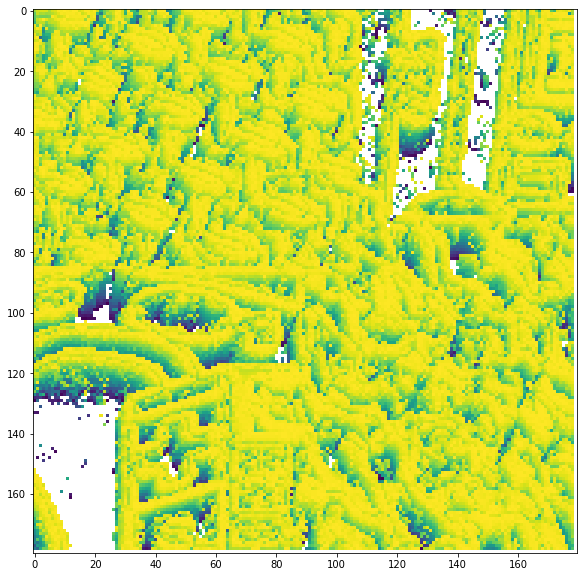

In [8]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events_p, shape, filter_polarity=False, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

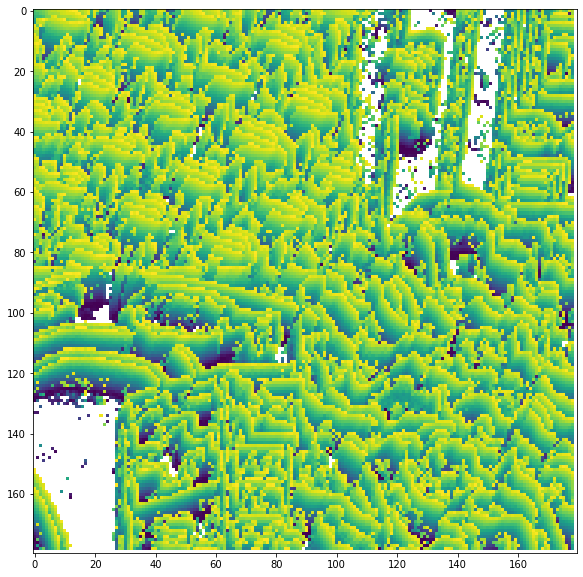

In [9]:
events = flt.filter_refract(events_p, 0.1)
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events, shape, filter_polarity=False, polarity=0)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

In [10]:
calib = np.loadtxt(path + dataset + "calib.txt")

In [11]:
poses = np.loadtxt(path + dataset + "groundtruth.txt")

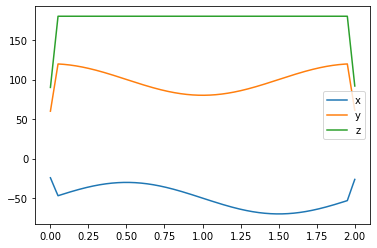

In [12]:
k = np.ones(100)
poses[:,1] = np.convolve(poses[:,1], k, mode="same")
poses[:,2] = np.convolve(poses[:,2], k, mode="same")
poses[:,3] = np.convolve(poses[:,3], k, mode="same")
poses[:,4] = np.convolve(poses[:,4], k, mode="same")
poses[:,5] = np.convolve(poses[:,5], k, mode="same")
poses[:,6] = np.convolve(poses[:,6], k, mode="same")
poses[:,7] = np.convolve(poses[:,7], k, mode="same")

plt.plot(poses[:,0], poses[:,1], label="x")
plt.plot(poses[:,0], poses[:,2], label="y")
plt.plot(poses[:,0], poses[:,3], label="z")
# plt.plot(poses[:,0], poses[:,4], label="q1")
# plt.plot(poses[:,0], poses[:,5], label="q2")
# plt.plot(poses[:,0], poses[:,6], label="q3")
# plt.plot(poses[:,0], poses[:,7], label="q4")
plt.legend()

In [13]:
def measure_td(events, shape, dist=1, start_delay=0.17):
    last_time = np.full(shape, -1.0)
    td_predictions = {}
    predictions = {}
    event_sign = np.full(shape, -1)

    U = np.zeros(shape)
    V = np.zeros(shape)

    start_time = events[0, 0]

    for e in tqdm(events):
        x = int(e[1])
        y = int(e[2])

        last_sign = event_sign[y, x]
        last_time[y, x] = e[0]
        event_sign[y, x] = e[3]

        if e[0] < start_time + start_delay:
            continue

        u_td = (e[0] - last_time[y - dist, x]
                if y - dist >= 0 and last_time[y - dist, x] != -1.0 and event_sign[y - dist, x] == e[3]
                else -1.0)
        d_td = (e[0] - last_time[y + dist, x]
                if y + dist < shape[0] and last_time[y + dist, x] != -1.0 and event_sign[y + dist, x] == e[3]
                else -1.0)
        r_td = (e[0] - last_time[y, x + dist]
                if x + dist < shape[1] and last_time[y, x + dist] != -1.0 and event_sign[y, x + dist] == e[3]
                else -1.0)
        l_td = (e[0] - last_time[y, x - dist]
                if x - dist >= 0 and last_time[y, x - dist] != -1.0 and event_sign[y, x - dist] == e[3]
                else -1.0)

        if u_td <= 0.0:
            if d_td <= 0.0:
                v_td = 0.0
                continue
            else:
                v_td = d_td
        else:
            if d_td > 0:
                #v_td = d_td if d_td >= u_td else -u_td
                v_td = 0.0
                continue
            else:
                v_td = -u_td

        if r_td <= 0.0:
            if l_td <= 0.0:
                h_td = 0.0
                continue
            else:
                h_td = l_td
        else:
            if l_td > 0:
                #h_td = l_td if l_td >= r_td else -r_td
                h_td = 0.0
                continue
            else:
                h_td = -r_td
                
        m = np.sqrt((1/h_td)**2 + (1/v_td)**2)
                
        U[y, x] = 1 / h_td# if h_td != 0.0 else 0.0
        V[y, x] = 1 / v_td #if v_td != 0.0 else 0.0
        
    return U, V

In [14]:
U, V = measure_td(events, shape, dist=2)

100%|████████████████████████████████████████████████████████████████████████| 85622/85622 [00:00<00:00, 287224.85it/s]


In [15]:
m = np.sqrt(U**2 + V**2)

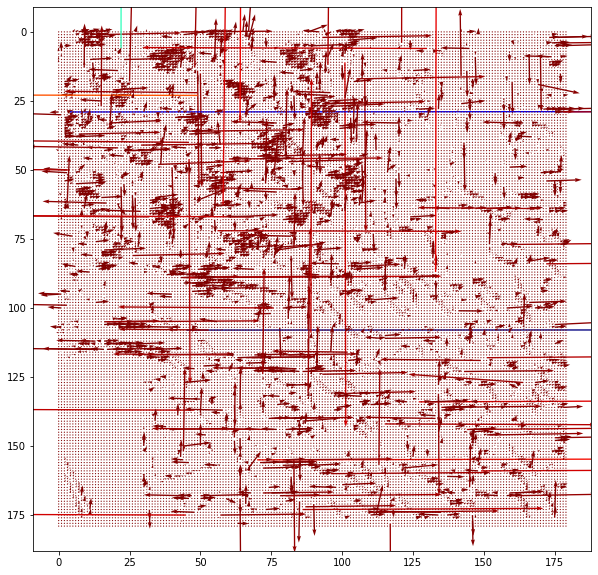

In [16]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(U, V, m, cmap="jet_r")
plt.gca().invert_yaxis()

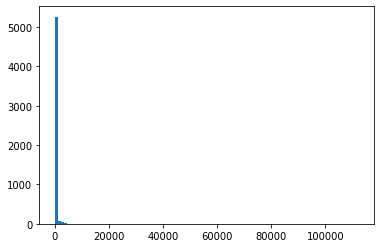

In [17]:
m_ma = np.ma.masked_where(np.isclose(m, 0.0), m)
plt.hist(m_ma.compressed(), 100);

In [114]:
time_d = td2d.TimeDifference2d(shape, events, poses, calib[0])
final_td, td_predictions, U, V, diff_list = time_d.compute_time_difference(dist = 2, px_range_pred=7, delay=0.19, avg_n=10, std_mul=0.005, debug=True, start_delay=0.05)
m = np.sqrt(U**2 + V**2)

(2, 1999)
[0. 0. 0.]


100%|█████████████████████████████████████████████████████████████████████████| 85622/85622 [00:06<00:00, 13866.10it/s]

total: 85622
diff: 2530
negative: 1408
q: 0
ang: 0
ind: 13704
img: 9708
filtered: 0


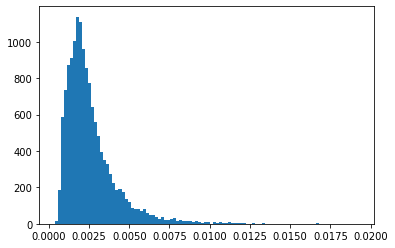

In [115]:
plt.hist(diff_list, 100);

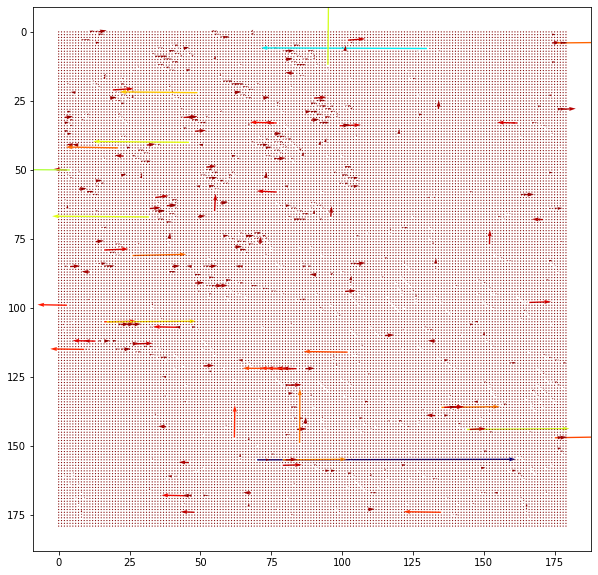

In [116]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(U, V, m, cmap="jet_r", scale=50000)
plt.gca().invert_yaxis()

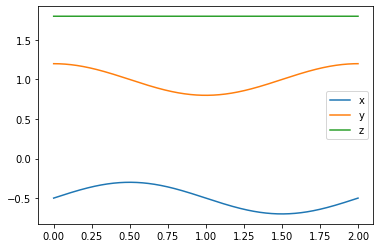

In [117]:
poses = np.loadtxt(path + dataset + "groundtruth.txt")
k = np.ones(10)
# poses[:,1] = np.convolve(poses[:,1], k, mode="same")
# poses[:,2] = np.convolve(poses[:,2], k, mode="same")
# poses[:,3] = np.convolve(poses[:,3], k, mode="same")
# poses[:,4] = np.convolve(poses[:,4], k, mode="same")
# poses[:,5] = np.convolve(poses[:,5], k, mode="same")
# poses[:,6] = np.convolve(poses[:,6], k, mode="same")
# poses[:,7] = np.convolve(poses[:,7], k, mode="same")

plt.plot(poses[:,0], poses[:,1], label="x")
plt.plot(poses[:,0], poses[:,2], label="y")
plt.plot(poses[:,0], poses[:,3], label="z")
# plt.plot(poses[:,0], poses[:,4], label="q1")
# plt.plot(poses[:,0], poses[:,5], label="q2")
# plt.plot(poses[:,0], poses[:,6], label="q3")
# plt.plot(poses[:,0], poses[:,7], label="q4")
plt.legend()

In [118]:
idx = np.searchsorted(poses[:, 0], t_start)
pose1 = poses[idx]
pose2 = poses[idx + 1]

ang1 = R.from_quat(pose1[4:]).as_euler("xyz")
ang2 = R.from_quat(pose2[4:]).as_euler("xyz")

vel = (ang2 - ang1) / (pose2[0] - pose1[0])

print(vel)

[0. 0. 0.]


In [119]:
def get_angular_flow(w, f, shape):
    U_flow = np.zeros(shape)
    V_flow = np.zeros(shape)
    for x in range(U_flow.shape[1]):
        for y in range(U_flow.shape[0]):
            xi = x - 90
            yi = y - 90
            # if np.mod(x, 10) != 0 or np.mod(y, 10) != 0:
            #     continue
            m = np.array([
                [(xi * yi) / f, -(f + xi ** 2 / f), yi],
                [f + yi ** 2 / f, -xi * yi / f, -xi]
            ])
            r = m @ w
            U_flow[y, x] = r[0]
            V_flow[y, x] = r[1]
            
    return U_flow, V_flow

In [120]:
ang_U, ang_V = get_angular_flow(vel, calib[0], shape)

c:\users\schiavaz\lava-nc\venv\lib\site-packages\matplotlib\quiver.py:689: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
c:\users\schiavaz\lava-nc\venv\lib\site-packages\matplotlib\quiver.py:689: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


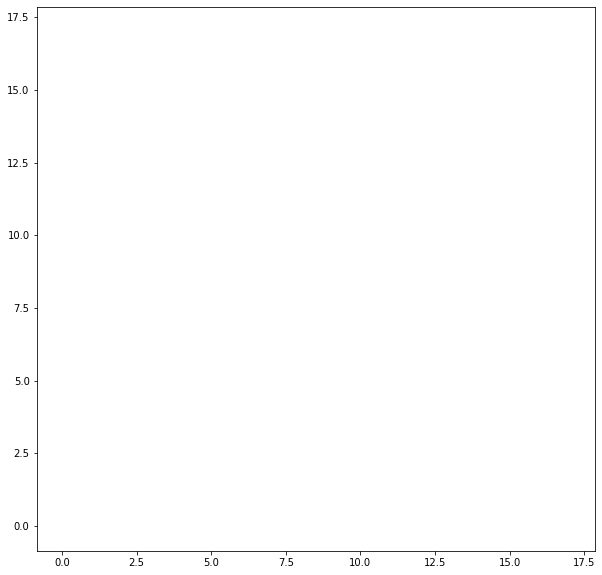

In [121]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(ang_U[::10, ::10], ang_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [191]:
idx = np.searchsorted(poses[:, 0], t_start + 0.19)
pose1 = poses[idx]
pose2 = poses[idx + 1]

t1 = pose1[1:4]
t2 = pose2[1:4]

print(t1)
print(t2)

t_vel = (t2 - t1) #/ (pose2[0] - pose1[0])

print(t_vel)
print(pose2[0] - pose1[0])

[-0.334353  0.887924  1.8     ]
[-0.334706  0.887404  1.8     ]
[-0.000353 -0.00052   0.      ]
0.0010000000000000009


In [192]:
def get_translational_flow(t, f, shape):
    U_flow = np.zeros(shape)
    V_flow = np.zeros(shape)
    for x in range(U_flow.shape[1]):
        for y in range(U_flow.shape[0]):
            xi = x - 90
            yi = y - 90
            # if np.mod(x, 10) != 0 or np.mod(y, 10) != 0:
            #     continue
            m = np.array([
                [-f, 0, xi],
                [0, -f, yi]
            ])
            r = m @ t
            U_flow[y, x] = r[0]
            V_flow[y, x] = r[1]
            
    return U_flow, V_flow

In [193]:
t_U, t_V = get_translational_flow(t_vel, calib[0], shape)

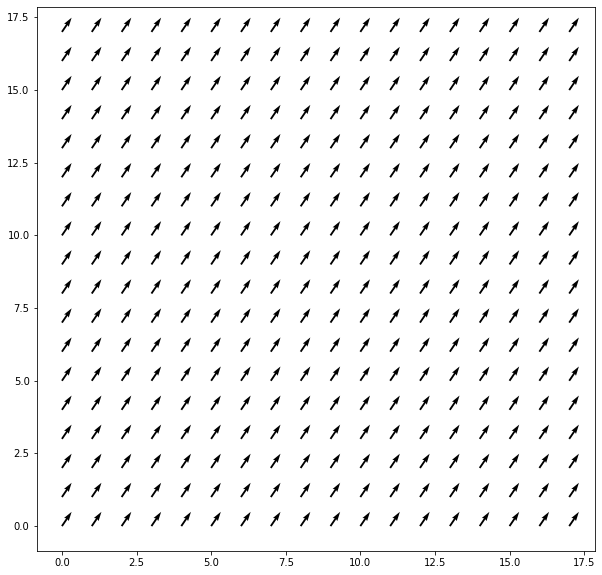

In [194]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(t_U[::10, ::10], t_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [195]:
flow_U = t_U + ang_U
flow_V = t_V + ang_V

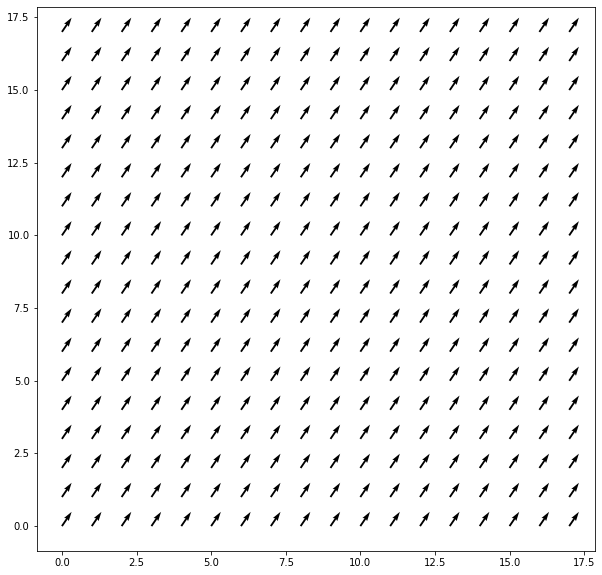

In [196]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(flow_U[::10, ::10], flow_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [205]:
test_u = np.zeros(shape)
test_v = np.zeros(shape)
test = np.zeros(shape)
for x in range(U.shape[1]):
    for y in range(U.shape[0]):
        
#         m = np.sqrt(np.square(U[y, x]) + np.square(V[y, x])) ** 2
#         l = (ang_U[y, x]* U[y, x] + ang_V[y, x] * V[y, x]) / m

#         if np.isclose(m, 0.0):
#             continue
        
#         ang_p_u = U[y, x] * l
#         ang_p_v = V[y, x] * l
        
        U_t = U[y, x] #- ang_p_u
        V_t = V[y, x] #- ang_p_v
        
#         test_u[y, x] = U_t
#         test_v[y, x] = V_t
        
        n = np.sqrt(t_U[y, x]**2 + t_V[y, x]**2) ** 2
        p = (U_t*t_U[y, x] + V_t*t_V[y, x]) / n
        
        u = t_U[y, x] * p
        v = t_V[y, x] * p
        
        a = t_U[y, x] * u if u != 0.0 else 0.0
        b = t_V[y, x] * v if v != 0.0 else 0.0
        
        if a+b <= 0.0:
            continue
        
        d = 1 / (a + b)
        
        d = np.sqrt(t_U[y, x]**2 + t_V[y, x]**2) / np.sqrt(u**2 + v**2)
        
        d = 1 / (t_U[y, x] / n * U_t + t_V[y, x] / n * V_t)
        
        if d > 0.002:
            continue
        
        test_u[y, x] = u
        test_v[y, x] = v

        test[y, x] = d

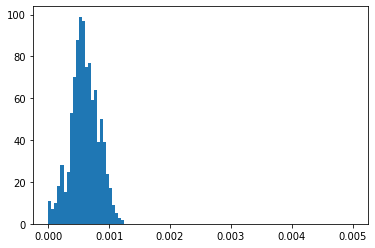

In [206]:
test_m = np.ma.masked_where(np.isclose(test, 0.0), test)
plt.hist(test_m.compressed(), 100, range=(0.0, 0.005));

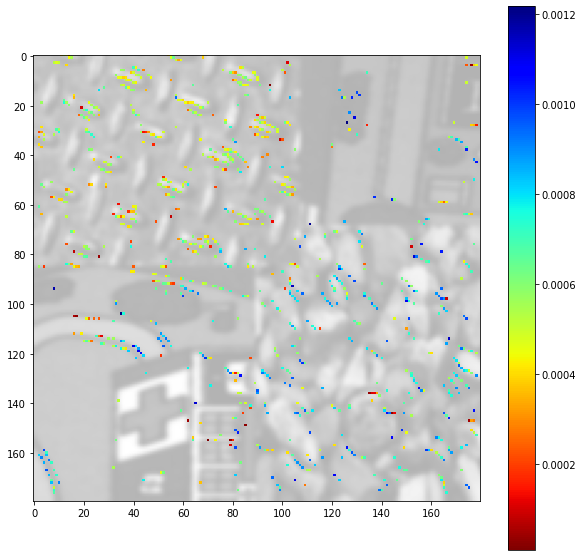

In [207]:
plt.figure(figsize=(10, 10))
img_gray = plt.imread(path + dataset + "images/frame_00000027.png")
plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(test_m, interpolation="none", cmap="jet_r")
plt.colorbar(m)

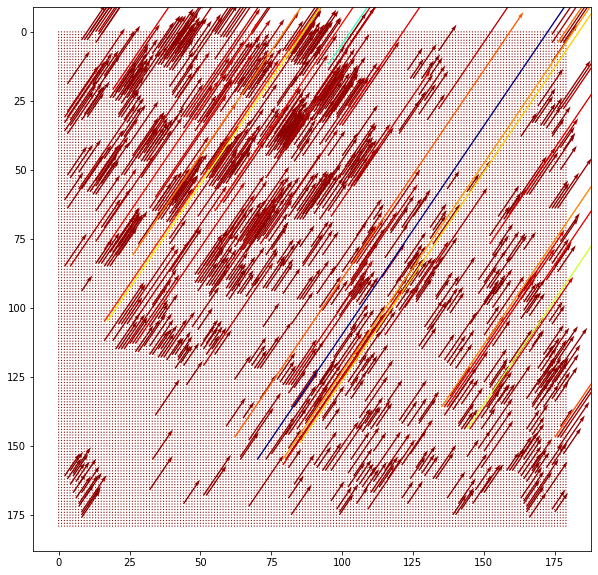

In [208]:
%matplotlib inline
m = np.sqrt(np.square(test_v) + np.square(test_u))
plt.figure(figsize=(10, 10))
plt.quiver(test_u[::1, ::1], test_v[::1, ::1], m, cmap="jet_r")
plt.gca().invert_yaxis()

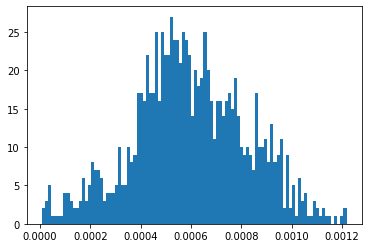

In [210]:
test_m = np.ma.masked_where(test == 0.0, test)
plt.hist(test_m.compressed(), 100);

In [211]:
%matplotlib qt
vis.visualize3d(test_m)

In [186]:
np.unravel_index(np.argmax(V), V.shape)

(12, 95)

In [187]:
np.max(V)

9108.048782707234

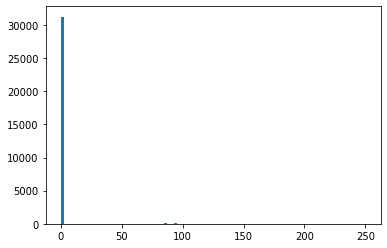

In [188]:
plt.hist(V.flatten(), 100, range=(0, 250));

In [189]:
1 / V[12, 95]

0.00010979300000002466

In [190]:
1 / U[12, 95]

0.012386828000000016